Артём Годунов 

**Специалист по Data Science**

telegram: @goodonoff

# Предсказание покупки в течение 90 дней

## 1. Описание проекта и данных

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель проекта:**

Предсказать вероятность покупки в течение 90 дней.

**Задачи проекта:**

- Изучить данные;
- Разработать полезные признаки;
- Создать модель для классификации пользователей;
- Улучшить модель и максимизировать метрику roc_auc;
- Выполнить тестирование.

**Исходные данные:**

- `apparel-purchases` - история покупок;
- `apparel-messages` - история рекламных рассылок;
- `apparel-target_binary` - совершит ли клиент покупку в течение следующих 90 дней.

Данные в `apparel-purchases`:
- **client_id** идентификатор пользователя;
- **quantity** количество товаров в заказе;
- **price** цена товара;
- **category_ids** вложенные категории, к которым отнсится товар;
- **date** дата покупки;
- **message_id** идентификатор сообщения из рассылки.

Данные в `apparel-messages`:
- **bulk_campaign_id** идентификатор рекламной кампании;
- **client_id** идентификатор пользователя;
- **message_id** идентификатор сообщений;
- **event** тип действия;
- **channel** канал рассылки;
- **date** дата рассылки;
- **created_at** точное время создания сообщения.

Данные в `apparel-target_binary`:
- **client_id** идентификатор пользователя;
- **target** целевой признак.

## 2. Загрузка и знакомство с данными

### 2.1. Загрузка библиотек, функций и надстроек

In [1]:
import pandas as pd 
import numpy as np 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import phik
import shap
import warnings
import ast 
import re
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/marketing-master2/full_campaign_daily_event.csv
/kaggle/input/marketing-master2/apparel-target_binary.csv
/kaggle/input/marketing-master2/full_campaign_daily_event_channel.csv
/kaggle/input/marketing-master2/apparel-messages.csv
/kaggle/input/marketing-master2/apparel-purchases.csv


In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

In [3]:
sns.set(font_scale=1)
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Создадим функцию для анализа данных
def describes (df):
    display(df.head());
    df.info();
    print('\nКоличество явных дубликатов', df.duplicated().sum())
    print('\nКоличество пропусков\n', df.isna().sum())

Установили все необходимые библиотеки. Создали функцию для первичного анализа данных.

### 2.2. Загрузка файлов и первичное знакомство

Загрузим и просмотрим данные в `apparel-purchases`

In [5]:
purchases = pd.read_csv('/kaggle/input/marketing-master2/apparel-purchases.csv')
describes(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB

Количество явных дубликатов 73020

Количество пропусков
 client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


Данные в `apparel-purchases` имееют **202208 строк**. Количество явных дубликатов - **73020**, что составляет примерно 1/3 от общего числа. Количество пропусков 0. 

Тип дынных в столбце **date** имеет не корректный тип данных.

Посмотрим на количество уникальных значений в столбце **quantity**, попробуем понять почему может быть такое большое количество явных дубликатов.

In [6]:
purchases['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

Большинство товаров куплено по 1 шт. Возможно эта ошибка записи данных, либо товары имеют разную спецификацию (цвет, размер). Если мы их удалим то потеряем около 1/3 данных поэтому оставим.

Загрузим и просмотрим данные в `apparel-messages`

In [7]:
messages = pd.read_csv('/kaggle/input/marketing-master2/apparel-messages.csv')
describes(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB

Количество явных дубликатов 48610

Количество пропусков
 bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


Данные в `apparel-messages` имеют **12739797 строк**. Количество янвых дубликатов **48610**, что меньше 1%. Скорее всего это ошибка записи данных. Нужно будет их удалить. Количество пропусков 0.

Не корректные типы данных в **date** и **created_at**.

Загрузим и просмотрим данные в `apparel-target_binary`

In [8]:
target = pd.read_csv('/kaggle/input/marketing-master2/apparel-target_binary.csv')
describes(target)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB

Количество явных дубликатов 0

Количество пропусков
 client_id    0
target       0
dtype: int64


Данные в `apparel-target_binary` содержит целевой признак и имеет **49849 строк**. Количество явных буликатов 0. Количество пропусков 0.

### 2.3. Выводы

Установили все необходимые библиотеки. Создали функцию для первичного анализа данных.

Данные в `apparel-purchases` имееют **202208 строк**. Количество явных дубликатов - **73020**, что составляет примерно 1/3 от общего числа. Количество пропусков 0. Тип дынных в столбце **date** имеет не корректный тип данных.

Посмотрели на количество уникальных значений в столбце **quantity**, попробывали понять почему может быть такое большое количество явных дубликатов. Большинство товаров куплено по 1 шт. Возможно эта ошибка записи данных, либо товары имеют разную спецификацию (цвет, размер). Если мы их удалим то потеряем около 1/3 данных поэтому оставим.

Данные в `apparel-messages` имеют **12739797 строк**. Количество явных дубликатов **48610**, что меньше 1%. Скорее всего это ошибка записи данных. Нужно будет их удалить. Количество пропусков 0. Не корректные типы данных в **date** и **created_at**.

Данные в `apparel-target_binary` содержит целевой признак и имеет **49849 строк**. Количество явных дубликатов 0. Количество пропусков 0.

## 3. Предобработка данных

### 3.1. Детальное изучение данных

Посмотрим на данные поглубже с помощью вывода уникальных значений.

In [9]:
# количество уникальных значений в purchases
purchases.nunique()

client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

In [10]:
# уникальные значения в столбце quantity
purchases['quantity'].unique()

array([ 1,  2,  3, 10,  4, 25, 20, 13, 30, 15,  6, 18,  8,  9,  5,  7])

**Состав данных в `purchases`:**
- 49849 данных уникальных пользователей;
- 16 вариантов кол-ва покупок за одну запись (самое маленькое число - 1, самое больше - 30);
- 3642 различных видов цен за товар;
- категории имеют вложенные категории и подкатегорию, уникальность таких комбинаций - 933;
- покупки были совершены в 642 днях за выбраннй период;
- покупателям было отправлено 50204 уникальных сообщения.

In [11]:
# количество уникальные значения в messages
messages.nunique()

bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

In [12]:
# уникальные значения в столбцах event и channel
print('Уникальные значение в столбце event', messages['event'].unique())
print('Уникальные значение в столбце channel', messages['channel'].unique())

Уникальные значение в столбце event ['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']
Уникальные значение в столбце channel ['email' 'mobile_push']


In [13]:
# количество уникальных значений в столбце event
messages['event'].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [14]:
# количество уникальных значений в столбце channel
messages['channel'].value_counts()

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

**Состав данных `messages`:**

- 2709 уникальных рассылок;
- данные о 53329 клиентах;
- 9061667 уникальных сообщений;
- 11 уникальных действий совершенных с сообщением (отправлено, открыто, нажато, куплено и так далее);
- 2 канала рассылок - через мобильное уведомление и чуть меньше через электронную почту;
- 638 уникальной даты сообщений;
- 4103539 значеней не только даты, но у разного времени в течение дня.

In [15]:
# # количество уникальные значения в target
target.nunique()

client_id    49849
target           2
dtype: int64

In [16]:
# уникальные значения в столбце target
target['target'].unique()

array([0, 1])

**Состав данных `target`:**

- все данные о клиентах уникальны, так как количество строк совпадает с количеством **client_id**;
- два вида целевого значения: 0 и 1

### 3.2. Работа с дубликатами и изменения типов данных

В прошлых шагах мы выявили дубликаты в данных `messages`, которые мы можем удалить. И изменим типы данных в столбцах со временем на корректные.

In [17]:
# удаление дубликатов
messages = messages.drop_duplicates()

In [18]:
# изменим типы данных
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')

purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')

In [19]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


In [20]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Теперь временыне столбцы имеют корреткные типы данных.

### 3.3. Вывод

Посмотрели на данные поглубже с помощью вывода уникальных значений.

**Состав данных в `purchases`:**
- 49849 данных уникальных пользователей;
- 16 вариантов кол-ва покупок за одну запись (самое маленькое число - 1, самое больше - 30);
- 3642 различных видов цен за товар;
- категории имеют вложенные категории и подкатегорию, уникальность таких комбинаций - 933;
- покупки были совершены в 642 днях за выбраннй период;
- покупателям было отправлено 50204 уникальных сообщения.

**Состав данных `messages`:**
- 2709 уникальных рассылок;
- данные о 53329 клиентах;
- 9061667 уникальных сообщений;
- 11 уникальных действий совершенных с сообщением (отправлено, открыто, нажато, куплено и так далее);
- 2 канала рассылок - через мобильное уведомление и чуть меньше через электронную почту;
- 638 уникальной даты сообщений;
- 4103539 значеней не только даты, но у разного времени в течение дня.

**Состав данных `target`:**
- все данные о клиентах уникальны, так как количество строк совпадает с количеством **client_id**;
- два вида целевого значения: 0 и 1.

В прошлых шагах мы выявили дубликаты в данных `messages`, которые мы удалили. И изменили типы данных в столбцах со временем на корректные.

## 4. Создание новых признаков и объединение данных

### 4.1 Создание новых признаков в `purchases`

#### 4.1.1 Новые признаки: первая и последняя категория **first_category и last_category**

In [21]:
# посмотрим данные в столбце category_ids
purchases['category_ids'].head(20)

0             ['4', '28', '57', '431']
1             ['4', '28', '57', '431']
2             ['4', '28', '57', '431']
3            ['4', '28', '244', '432']
4             ['4', '28', '49', '413']
5            ['2', '18', '258', '441']
6           ['2', '18', '341', '1311']
7            ['2', '18', '123', '451']
8      ['5562', '5631', '5549', '667']
9      ['5562', '5630', '5649', '678']
10            ['4', '28', '57', '431']
11          ['4', '27', '350', '1392']
12          ['4', '27', '350', '1392']
13            ['4', '28', '44', '490']
14           ['2', '18', '267', '443']
15           ['4', '28', '213', '417']
16    ['5562', '5589', '5584', '1786']
17    ['5562', '5589', '5584', '1795']
18     ['5562', '5630', '5699', '550']
19            ['4', '28', '57', '431']
Name: category_ids, dtype: object

Мы не знаем, что это конкретно за категории и как они иногда изменяются. Скорее всего самая первая цифра эта главная категория, а последняя цифра это итоговый купленный товар. Первые числа в категориях идут по возрастанию, а у последней цифры такое не наблюдается. Поэтому выделим первую и послденнюю категорию в отдельные столбцы.

In [22]:
# функция для выделения первого и последнего числа
def extract_first_last(lst_str):
    try:
        if not isinstance(lst_str, str) or lst_str.strip() in ["", "[]", "None"]:
            return np.nan, np.nan  # Если значение некорректно, возвращаем NaN
        
        lst = ast.literal_eval(lst_str)  # Преобразуем строку в список
        if isinstance(lst, list) and len(lst) > 0:
            return lst[0], lst[-1]  # Возвращаем первый и последний элемент
        else:
            return np.nan, np.nan  # Если список пуст, возвращаем NaN
    except (SyntaxError, ValueError):
        return np.nan, np.nan  # Если ошибка преобразования, возвращаем NaN

# Проверяем и создаем новые столбцы
purchases[['first_category', 'last_category']] = purchases['category_ids'].apply(lambda x: pd.Series(extract_first_last(x)))

In [23]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,first_category,last_category
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,431
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,432
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,413


#### 4.1.2 Группировка данных

Удалим лишние столбцы.

In [24]:
purchases = purchases.drop(['category_ids','message_id'], axis=1)

Сгрупируем данные по **client_id**

In [25]:
purchases = purchases.groupby('client_id').agg({
    'quantity': 'sum', 
    'price': 'sum', 
    'date': 'max', 
    # самая популярная первая категория:
    'first_category': lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    # самая популярная последняя категория
    'last_category': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()

Переименуем некоторые столбцы по логике объединения.

In [26]:
purchases = purchases.rename(columns={'date': 'date_last_pur',
                                      'quantity': 'total_quantity',
                                      'price': 'total_price'
                                     })

In [27]:
purchases.sample(10)

,client_id,total_quantity,total_price,date_last_pur,first_category,last_category
32070,1515915625580967211,2,2998.0,2023-08-14,4,420
47847,1515915625973791154,6,3328.0,2023-06-02,4,524
33053,1515915625585272949,8,6695.0,2023-09-02,2,1431
22821,1515915625542715856,22,2354.0,2023-06-01,5562,574
22898,1515915625544007072,6,12204.0,2023-04-27,4,657
8917,1515915625488717963,2,1600.0,2022-12-28,4,934
25960,1515915625558629988,2,2998.0,2023-04-14,4,420
8952,1515915625488732871,6,5894.0,2022-07-14,4,431
27295,1515915625559509147,2,1716.0,2023-04-30,4,421
16536,1515915625491442179,6,3278.0,2023-06-13,4,1834


#### 4.1.3 Новый признак: количество дней без покупки **days_no_pur**

Найдем самую последнюю дату покупки и примем ее за день выгрузки данных.

In [28]:
pur_max_date = purchases['date_last_pur'].max()
pur_max_date

Timestamp('2024-02-16 00:00:00')

Вычтем из полученного числа, последний день продажи у конкретного клиента.

In [29]:
#количество дней с последней покупки
purchases['days_no_pur'] = (pur_max_date - purchases['date_last_pur']).dt.days

In [30]:
purchases.head()

,client_id,total_quantity,total_price,date_last_pur,first_category,last_category,days_no_pur
0,1515915625468060902,7,6993.0,2022-05-27,4,420,630
1,1515915625468061003,7,16235.0,2023-01-04,4,615,408
2,1515915625468061099,1,299.0,2022-05-17,4,424,640
3,1515915625468061100,2,2098.0,2024-02-10,4,5717,6
4,1515915625468061170,19,33601.0,2023-06-17,4,420,244


In [31]:
purchases = purchases.drop(['date_last_pur'], axis=1)

### 4.2 Создание новых признаков в `messages`

In [32]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


#### 4.2.1 Новые признаки: типы и количество эвентов в сообщениях

In [33]:
messages['event_send'] = (messages['event'] == 'send').astype(int) # сообщение отправлено
messages['event_purchase'] = (messages['event'] == 'purchase').astype(int) # совершена покупка
messages['event_good'] = ((messages['event'] == 'open') | 
                          (messages['event'] == 'click') | 
                          (messages['event'] == 'subscribe')).astype(int) # положительное событие (открытие или нажатие или подписка)
messages['event_bad'] = ((messages['event'] == 'unsubscribe') | 
                         (messages['event'] == 'complain') | 
                         (messages['event'] == 'close')).astype(int) # отрицательное событие (отписка или жалоба или закрытие)
messages['event_problem'] = ((messages['event'] == 'hard_bounce') | 
                             (messages['event'] == 'soft_bounce') | 
                             (messages['event'] == 'hbq_spam')).astype(int) # техническая проблема (ошибки или спам)

#### 4.2.2 Новые признаки: количество отправленных сообщений с учетом канала взаимодействия

In [34]:
messages['send_email'] = ((messages['event'] == 'send') & 
                          (messages['channel'] == 'email')).astype(int) # отправлено через электронную почту
messages['send_push'] = ((messages['event'] == 'send') & 
                         (messages['channel'] == 'mobile_push')).astype(int) # отправлено через мобильное уведомление

#### 4.2.3 Новый признак: дата последнего отправленного сообщения

In [35]:
messages['last_send_date'] = messages['date'].where(messages['event'] == 'send')

In [36]:
messages.sample(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,event_send,event_purchase,event_good,event_bad,event_problem,send_email,send_push,last_send_date
9415752,14135,1515915625468131296,1515915625468131296-14135-65572182b4be4,send,email,2023-11-17,2023-11-17 08:24:42,1,0,0,0,0,1,0,2023-11-17
5990865,13427,1515915625543160704,1515915625543160704-13427-649e83c4c1302,send,email,2023-06-30,2023-06-30 13:54:25,1,0,0,0,0,1,0,2023-06-30
5148099,12650,1515915625479774118,1515915625479774118-12650-6467343f2d6c9,send,email,2023-05-19,2023-05-19 12:55:06,1,0,0,0,0,1,0,2023-05-19
5818692,13379,1515915625491398752,1515915625491398752-13379-6491b74d6c4c2,send,mobile_push,2023-06-20,2023-06-20 14:43:28,1,0,0,0,0,0,1,2023-06-20
9662324,14182,1515915625559387711,1515915625559387711-14182-65605668e3390,send,email,2023-11-24,2023-11-24 11:18:10,1,0,0,0,0,1,0,2023-11-24


#### 4.2.4 Группировка данных

Удалим лишние столбцы

In [37]:
messages = messages.drop(['event','message_id', 'channel', 'date', 'created_at'], axis=1)

Сгруппируем данные по **client_id**

In [38]:
messages = messages.groupby('client_id').agg({
    'bulk_campaign_id': 'nunique', 
    'event_send': 'sum', 
    'event_purchase': 'sum', 
    'event_good': 'sum', 
    'event_bad': 'sum', 
    'event_problem': 'sum', 
    'send_email': 'sum', 
    'send_push': 'sum', 
    'last_send_date': 'max' 
}).reset_index()

#### 4.2.5 Новый признак: количество дней прошедших с последней отправки сообщения

In [39]:
messages['days_no_send'] = (pur_max_date - messages['last_send_date']).dt.days

In [40]:
messages.sample(10)

,client_id,bulk_campaign_id,event_send,event_purchase,event_good,event_bad,event_problem,send_email,send_push,last_send_date,days_no_send
32722,1515915625566728954,163,175,1,82,0,4,0,175,2024-02-14,2.0
23538,1515915625501792666,280,284,0,151,0,0,14,270,2024-02-15,1.0
28154,1515915625556879963,269,265,1,278,0,1,23,242,2024-02-15,1.0
28714,1515915625558000522,93,97,0,2,0,0,0,97,2024-02-15,1.0
13640,1515915625489654119,31,31,1,26,0,0,31,0,2022-09-16,518.0
36676,1515915625590769145,218,220,0,12,0,0,0,220,2024-02-14,2.0
27397,1515915625551241311,252,258,5,26,0,0,0,258,2024-02-14,2.0
23643,1515915625502018060,77,82,0,10,0,0,0,82,2024-02-14,2.0
33886,1515915625572249731,169,170,2,32,0,0,18,152,2024-02-15,1.0
34445,1515915625576697494,152,157,0,152,0,0,0,157,2024-02-15,1.0


Удалим лишние столбцы. У **bulk_campaign_id** и **event_send** видна сильная корреляция, поэтому сразу уберем один из признаков. Удалим **last_send_date**, так как добавили новый признак на основе этого столбца.

In [41]:
messages = messages.drop(['bulk_campaign_id','last_send_date'], axis=1)

### 4.3 Объединим три таблицы в одну

In [42]:
df = target.merge(purchases, on='client_id', how='left')
df = df.merge(messages, on='client_id', how='left')

Посмотрим на данные объединенной таблицы.

In [43]:
describes(df)

,client_id,target,total_quantity,total_price,first_category,last_category,days_no_pur,event_send,event_purchase,event_good,event_bad,event_problem,send_email,send_push,days_no_send
0,1515915625468060902,0,7,6993.0,4,420,630,126.0,5.0,45.0,1.0,0.0,126.0,0.0,28.0
1,1515915625468061003,1,7,16235.0,4,615,408,154.0,1.0,10.0,0.0,0.0,154.0,0.0,3.0
2,1515915625468061099,0,1,299.0,4,424,640,215.0,0.0,59.0,0.0,2.0,157.0,58.0,3.0
3,1515915625468061100,0,2,2098.0,4,5717,6,267.0,1.0,158.0,0.0,2.0,0.0,267.0,1.0
4,1515915625468061170,0,19,33601.0,4,420,244,243.0,3.0,47.0,0.0,0.0,164.0,79.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       49849 non-null  int64  
 1   target          49849 non-null  int64  
 2   total_quantity  49849 non-null  int64  
 3   total_price     49849 non-null  float64
 4   first_category  49848 non-null  object 
 5   last_category   49848 non-null  object 
 6   days_no_pur     49849 non-null  int64  
 7   event_send      41982 non-null  float64
 8   event_purchase  41982 non-null  float64
 9   event_good      41982 non-null  float64
 10  event_bad       41982 non-null  float64
 11  event_problem   41982 non-null  float64
 12  send_email      41982 non-null  float64
 13  send_push       41982 non-null  float64
 14  days_no_send    41981 non-null  float64
dtypes: float64(9), int64(4), object(2)
memory usage: 5.7+ MB

Количество явных дубликатов 0

Количество пропусков
 client_id 

После объединения таблиц у нас получилось **49848 строк**. Количество явных дубликатов 0. Есть по одному пропуску в **first_category** и **last_category** и 7867 пропусков в столбцах из таблицы **messages**. Так как данных много и не хочется их терять, а понять были ли отправлены какие-нибудь сообщения этим покупателям мы не можем, поэтому заполним пропуски нулями.

In [44]:
df = df.fillna(0)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       49849 non-null  int64  
 1   target          49849 non-null  int64  
 2   total_quantity  49849 non-null  int64  
 3   total_price     49849 non-null  float64
 4   first_category  49849 non-null  object 
 5   last_category   49849 non-null  object 
 6   days_no_pur     49849 non-null  int64  
 7   event_send      49849 non-null  float64
 8   event_purchase  49849 non-null  float64
 9   event_good      49849 non-null  float64
 10  event_bad       49849 non-null  float64
 11  event_problem   49849 non-null  float64
 12  send_email      49849 non-null  float64
 13  send_push       49849 non-null  float64
 14  days_no_send    49849 non-null  float64
dtypes: float64(9), int64(4), object(2)
memory usage: 5.7+ MB


Заменили пропуски.

### 4.4 Выводы

**Создали новые признаки в `purchases`.** 
Новые признаки: первая и последняя категория **first_category и last_category**. Мы не знаем, что это конкретно за категории и как они иногда изменяются. Скорее всего самая первая цифра эта главная категория, а последняя цифра это итоговый купленный товар. Первые числа в категориях идут по возрастанию, а у последней цифры такое не наблюдается. Поэтому выделим первую и послденнюю категорию в отдельные столбцы. После группировки данных создали новый признак: количество дней без покупки **days_no_pur**.

**Создали новые признаки в `messages`.**
Новые признаки: типы и количество эвентов в сообщениях **event_send, event_purchase, event_good, event_bad', event_problem**. Количество отправленных сообщений с учетом канала взаимодействия **send_email, send_push**. Дата последнего отправленного сообщения **last_send_date**. После группировки данных создали новый признак: количество дней прошедших с последней отправки сообщения **days_no_send**.

Удалили лишние столбцы, которые являются производными от других столбцов и столбцы с явной корреляцией.

**Объединили три таблицы в одну**. После объединения таблиц у нас получилось **49848 строк**. Количество явных дубликатов 0. Есть по одному пропуску в **first_category** и **last_category** и 7867 пропусков в столбцах из таблицы **messages**. Так как данных много и не хочется их терять, а понять были ли отправлены какие-нибудь сообщения этим покупателям мы не можем, поэтому заполнили пропуски нулями.

## 5. Исследовательский анализ данных

### 5.1 Соотношение целевого признака

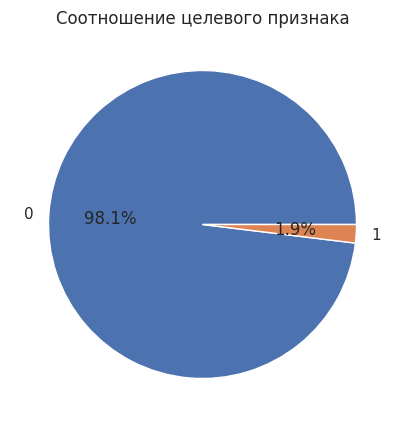

In [46]:
target_ratio = df['target'].value_counts()

# Построение кругового графика
plt.figure(figsize=(5, 5)) 
plt.pie(target_ratio, labels=target_ratio.index, autopct='%1.1f%%')
plt.title('Соотношение целевого признака')
plt.show()

Явно наблюдаем дисбаланс целевого признака **98.1%** со значением 0 и **1.9%** со значением 1.

### 5.2. Построим графики числовых столбцов

In [47]:
# посмотрим на числовые данные
df.describe()

,client_id,target,total_quantity,total_price,days_no_pur,event_send,event_purchase,event_good,event_bad,event_problem,send_email,send_push,days_no_send
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,0.019278,4.082710,4840.520632,361.931593,158.458485,1.117455,58.764368,0.062388,0.522398,72.792895,85.665590,33.763927
std,1.487947e+08,0.137503,5.562927,7312.865458,185.301691,118.018354,1.297344,75.387906,0.535679,2.848855,69.118577,96.649123,110.183133
min,1.515916e+18,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,0.000000,1.000000,1499.000000,233.000000,59.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.515916e+18,0.000000,2.000000,2929.000000,348.000000,151.000000,1.000000,24.000000,0.000000,0.000000,63.000000,51.000000,1.000000
75%,1.515916e+18,0.000000,5.000000,5677.000000,542.000000,243.000000,1.000000,92.000000,0.000000,0.000000,135.000000,161.000000,3.000000
max,1.515916e+18,1.000000,355.000000,540408.000000,641.000000,2473.000000,81.000000,1437.000000,80.000000,134.000000,321.000000,2152.000000,638.000000


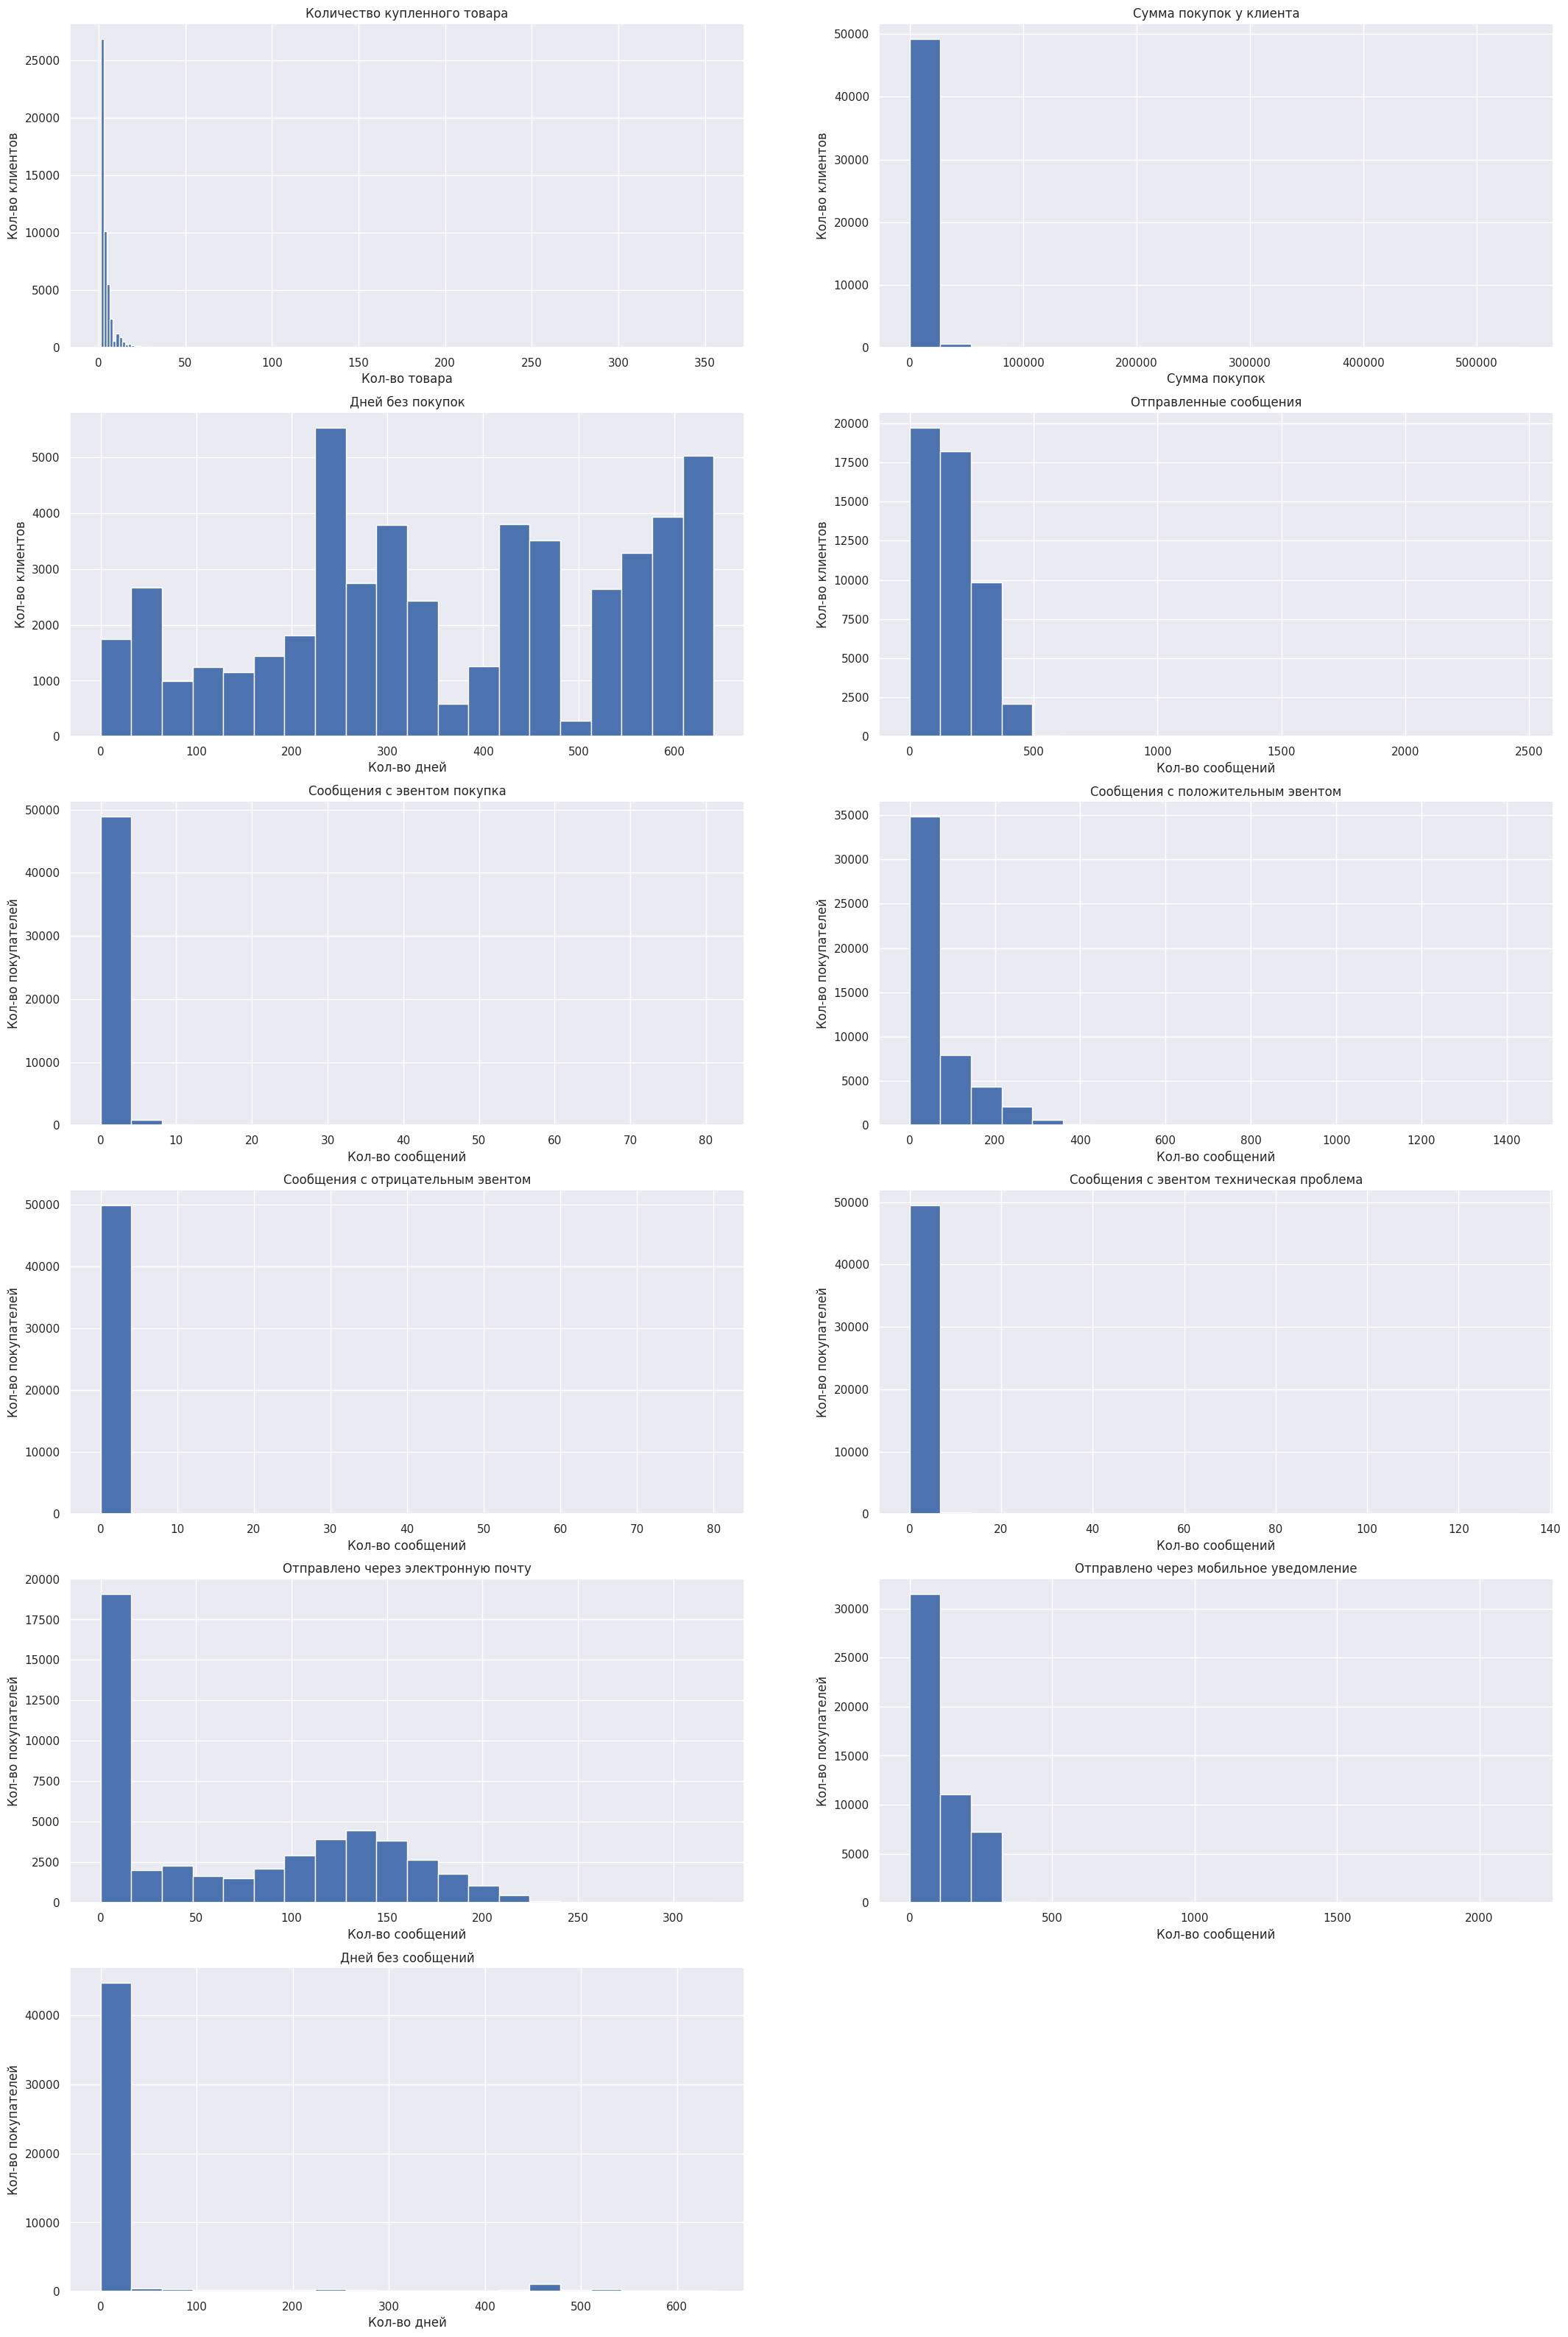

In [48]:
# построим графики
fig, axs = plt.subplots(6, 2, figsize=(26, 40))

df['total_quantity'].hist(bins=200, ax=axs[0, 0])
axs[0, 0].set_title('Количество купленного товара')
axs[0, 0].set_xlabel('Кол-во товара')
axs[0, 0].set_ylabel('Кол-во клиентов')

df['total_price'].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title('Сумма покупок у клиента')
axs[0, 1].set_xlabel('Сумма покупок')
axs[0, 1].set_ylabel('Кол-во клиентов')

df['days_no_pur'].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title('Дней без покупок')
axs[1, 0].set_xlabel('Кол-во дней')
axs[1, 0].set_ylabel('Кол-во клиентов')

df['event_send'].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title('Отправленные сообщения')
axs[1, 1].set_xlabel('Кол-во сообщений')
axs[1, 1].set_ylabel('Кол-во клиентов')

df['event_purchase'].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title('Сообщения с эвентом покупка')
axs[2, 0].set_xlabel('Кол-во сообщений')
axs[2, 0].set_ylabel('Кол-во покупателей')

df['event_good'].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title('Сообщения с положительным эвентом')
axs[2, 1].set_xlabel('Кол-во сообщений')
axs[2, 1].set_ylabel('Кол-во покупателей')

df['event_bad'].hist(bins=20, ax=axs[3, 0])
axs[3, 0].set_title('Сообщения с отрицательным эвентом')
axs[3, 0].set_xlabel('Кол-во сообщений')
axs[3, 0].set_ylabel('Кол-во покупателей')

df['event_problem'].hist(bins=20, ax=axs[3, 1])
axs[3, 1].set_title('Сообщения с эвентом техническая проблема')
axs[3, 1].set_xlabel('Кол-во сообщений')
axs[3, 1].set_ylabel('Кол-во покупателей')

df['send_email'].hist(bins=20, ax=axs[4, 0])
axs[4, 0].set_title('Отправлено через электронную почту')
axs[4, 0].set_xlabel('Кол-во сообщений')
axs[4, 0].set_ylabel('Кол-во покупателей')

df['send_push'].hist(bins=20, ax=axs[4, 1])
axs[4, 1].set_title('Отправлено через мобильное уведомление')
axs[4, 1].set_xlabel('Кол-во сообщений')
axs[4, 1].set_ylabel('Кол-во покупателей')

df['days_no_send'].hist(bins=20, ax=axs[5, 0])
axs[5, 0].set_title('Дней без сообщений')
axs[5, 0].set_xlabel('Кол-во дней')
axs[5, 0].set_ylabel('Кол-во покупателей')

fig.delaxes(axs[5, 1])

plt.show()

После построения графиков и изучения данных мы увидели, что:
- количество **купленного товара** чаще всего приходится около **2** на клиента, при этом самое большое количество **355**;
- **сумма покупок** на клиента чаще всего составялет около **2929**, а самая большая **540408**;
- кол-во **дней без покупок** чаще всего находится около **250** и более **600** дней;
- кол-во **отправленных сообщений** самое большое приходится до **150 шт**, при этом среднее значение близко к медионному и составляет **362**;
- сообщений с **эвентом покупка** чаще всего **1** на человека, а самое большое **81**;
- сообщений с **положительным эвентом** чаще всего меньше **30** на клиента, а самое большое **1437**;
- сообщений с **отрицательным эвентом** чаще всего около **0** на клиента, а самое большое **80**;
- сообщений с **эвентом тех проблем** чаще всего около **0** на клиента, а самое большое **134**;
- сообщений отправленных **электронной почтой** чаще всего до **25**, а медианное значение **63**, самое большое число **321**;
- сообщений отправленных **уведомлениями на мобильный** чаще всего до **100**, а медианное значение **51**, самое большое число **2152**;
- дней без отправки сообщений меданное значение **1**, а смое большое число **638**.

Мы видим что все нет данных у которых нормальное распределение. И много столбцов с выбросами. Наши модели должны нормально отработать эти выбросы, но если мы не сможем приблизиться к целевым показателям, то нужно будет избавиться от выбросов.

### 5.3 Построим графики для категориальных признаков

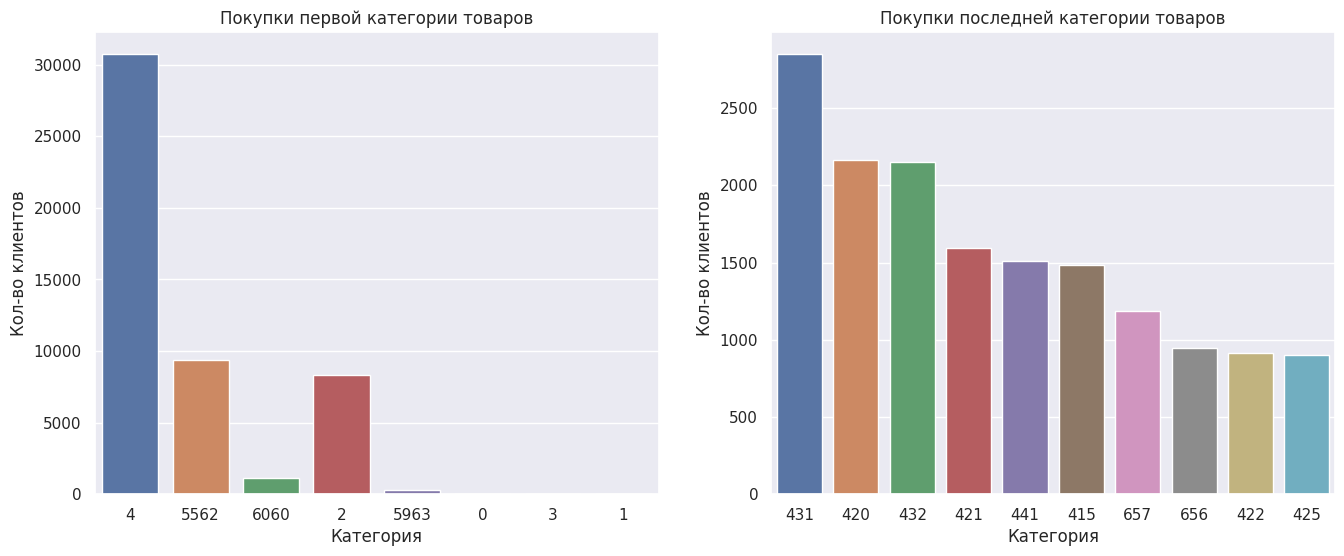

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# График для first_category
sns.countplot(x='first_category', data=df, ax=axs[0]).set(
    title='Покупки первой категории товаров',
    xlabel='Категория', 
    ylabel='Кол-во клиентов'
)

# Получаем топ-10 самых популярных категорий для last_category
top10_categories = df['last_category'].value_counts().index[:10]

# Строим график для last_category, ограничив его только топ-10 категориями
sns.countplot(x='last_category', data=df, order=top10_categories, ax=axs[1]).set(
    title='Покупки последней категории товаров',
    xlabel='Категория', 
    ylabel='Кол-во клиентов'
)

plt.show()

После построения графиков для категориальных данных мы увидели, что:
- самая популярная главная категория с большим отрывом является **4**, на втором месте **5562**, на третьем **2**;
- самая поплярная последняя категория **431**, на втором месте **420**, на третьем месте **432**.

### 5.4 Корреляционный анализ данных

In [50]:
# удалим столбец client_id
df_new = df.drop(['client_id'], axis=1)

Зададим актуальные типы данных для столбцов.

In [51]:
df_new['target'] = df_new['target'].astype(str)
df_new['total_quantity'] = df_new['total_quantity'].astype(int)
df_new['total_price'] = df_new['total_price'].astype(int)
df_new['first_category'] = df_new['first_category'].astype(str)
df_new['last_category'] = df_new['last_category'].astype(str)
df_new['days_no_pur'] = df_new['days_no_pur'].astype(int)
df_new['event_send'] = df_new['event_send'].astype(int)
df_new['event_purchase'] = df_new['event_purchase'].astype(int)
df_new['event_good'] = df_new['event_good'].astype(int)
df_new['event_bad'] = df_new['event_bad'].astype(int)
df_new['event_problem'] = df_new['event_problem'].astype(int)
df_new['send_email'] = df_new['send_email'].astype(int)
df_new['send_push'] = df_new['send_push'].astype(int)
df_new['days_no_send'] = df_new['days_no_send'].astype(int)

Построим матрицу корреляции.

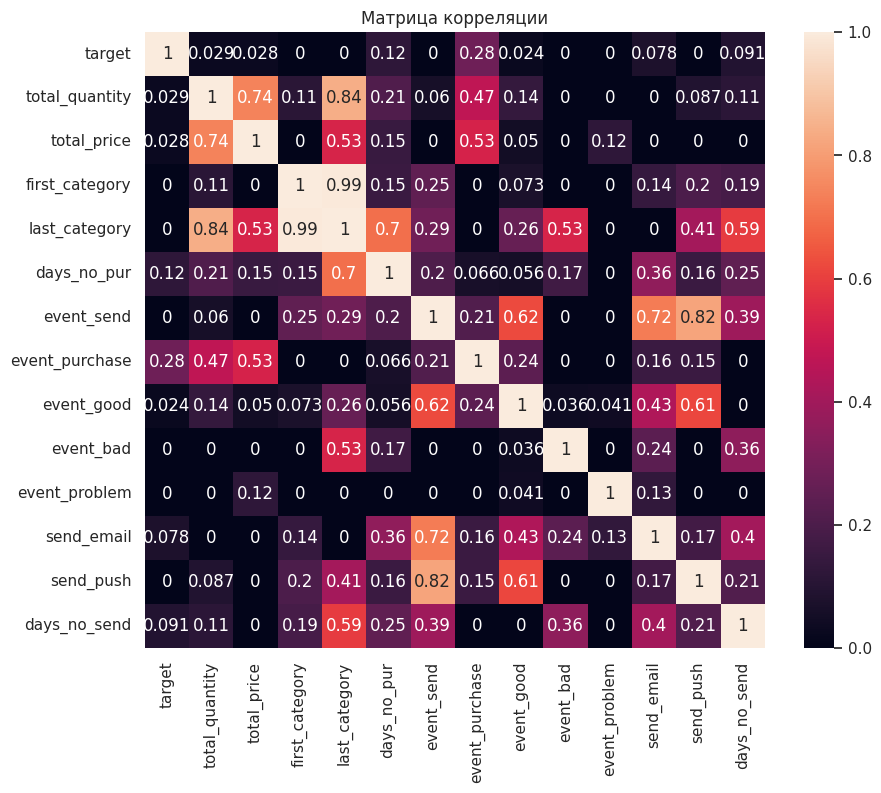

In [52]:
# Возьмем 1000 строк
sampled_df = df_new.sample(n=1000, random_state=42)

corr_matrix = sampled_df.phik_matrix(interval_cols=['total_quantity', 'total_price', 
                                                    'days_no_pur', 'event_send', 
                                                    'days_no_send','event_purchase',
                                                    'event_good', 'event_bad', 'event_problem',
                                                    'send_email', 'send_push'
                                                   ])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Матрица корреляции')
plt.show()

После построения матрицы корреляции мы видим, что есть почти прямая корреляция у **first_category** и **last_category**, оставим только 1 категорию. Есть корреляция между признакми **event_send**, **send_mail** и **send_push**. Уберем столбец **event_send**.

In [53]:
df_new = df.drop(['first_category', 'event_send'], axis=1)

### 5.5 Вывод

После построения графика для целевого признака мы явно наблюдаем дисбаланс целевого признака **98.1%** со значением 0 и **1.9%** со значением 1.

Построили графики для числовых столбцов. После построения графиков и изучения данных мы увидели, что:
- количество **купленного товара** чаще всего приходится около **2** на клиента, при этом самое большое количество **355**;
- **сумма покупок** на клиента чаще всего составялет около **2929**, а самая большая **540408**;
- кол-во **дней без покупок** чаще всего находится около **250** и более **600** дней;
- кол-во **отправленных сообщений** самое большое приходится до **150 шт**, при этом среднее значение близко к медионному и составляет **362**;
- сообщений с **эвентом покупка** чаще всего **1** на человека, а самое большое **81**;
- сообщений с **положительным эвентом** чаще всего меньше **30** на клиента, а самое большое **1437**;
- сообщений с **отрицательным эвентом** чаще всего около **0** на клиента, а самое большое **80**;
- сообщений с **эвентом тех проблем** чаще всего около **0** на клиента, а самое большое **134**;
- сообщений отправленных **электронной почтой** чаще всего до **25**, а медианное значение **63**, самое большое число **321**;
- сообщений отправленных **уведомлениями на мобильный** чаще всего до **100**, а медианное значение **51**, самое большое число **2152**;
- дней без отправки сообщений меданное значение **1**, а смое большое число **638**.

Мы видим что все нет данных у которых нормальное распределение. И много столбцов с выбросами. Наши модели должны нормально отработать эти выбросы, но если мы не сможем приблизиться к целевым показателям, то нужно будет избавиться от выбросов.

Построили графики для категориальных признаков. После построения графиков для категориальных данных мы увидели, что:
- самая популярная главная категория с большим отрывом является **4**, на втором месте **5562**, на третьем **2**;
- самая поплярная последняя категория **431**, на втором месте **420**, на третьем месте **432**.

Убрали столбец **client_id** и построили матрицу корреляции. После построения матрицы корреляции мы видим, что есть почти прямая корреляция у **first_category** и **last_category**, оставим только 1 категорию. Есть корреляция между признакми **event_send**, **send_mail** и **send_push**. Убрали столбец **event_send**.

## 6. Обучение моделей

### 6.1 Подготовка к обучению и создание паплайна

In [54]:
# проверим на наличие дубликатов
print('Количество дубликатов:', df_new.duplicated().sum())

Количество дубликатов: 0


In [55]:
# на всякий случай еще раз обозначим типы данных
df_new['target'] = df_new['target'].astype(str)
df_new['total_quantity'] = df_new['total_quantity'].astype(int)
df_new['total_price'] = df_new['total_price'].astype(int)
df_new['last_category'] = df_new['last_category'].astype(str)
df_new['days_no_pur'] = df_new['days_no_pur'].astype(int)
df_new['event_purchase'] = df_new['event_purchase'].astype(int)
df_new['event_good'] = df_new['event_good'].astype(int)
df_new['event_bad'] = df_new['event_bad'].astype(int)
df_new['event_problem'] = df_new['event_problem'].astype(int)
df_new['send_email'] = df_new['send_email'].astype(int)
df_new['send_push'] = df_new['send_push'].astype(int)
df_new['days_no_send'] = df_new['days_no_send'].astype(int)

In [56]:
# разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    df_new.drop(['target'], axis=1),
    df_new['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_new['target']
)

X_train.shape, X_test.shape,y_train.shape, y_test.shape

((37386, 12), (12463, 12), (37386,), (12463,))

In [57]:
cat_columns = X_train.select_dtypes(exclude='number').columns.tolist()
num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [58]:
# создаем пайплайны для подготовки признаков
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('sImputer_nan_mf', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('sImputer_sp_mf', SimpleImputer(missing_values = ' ', strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# SimpleImputer + Scaler
num_pipe = Pipeline(
    [
        ('sImputer_nan_med', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# создаем общий пайплайн подтоговки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', ohe_pipe, cat_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
)

### 6.2 Поиск лучшей модели и метрик

In [59]:
param_grid = [
    
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(loss_function="Logloss")],
        'models__iterations':range(20, 100),
        'models__max_depth': range(7, 10),   
        'models__learning_rate':[0.5, 0.68, 0.7, 0.8],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMClassifier
    {
        'models': [LGBMClassifier()],
        'models__n_estimators':range(25, 100),
        'models__num_leaves': range(20, 40),        
        'models__reg_alpha': [0.1, 0.2, 0.5],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__penalty': ['l2'],  
       'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]
grid = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=50    
)
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:')
display(grid.best_estimator_.named_steps['models'])

print ('Метрика ROC-AUC на тренировочной выборке:', grid.best_score_.round(3))

[LightGBM] [Info] Number of positive: 721, number of negative: 36665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2320
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019285 -> initscore=-3.928939
[LightGBM] [Info] Start training from score -3.928939
Лучшая модель и её параметры:


LGBMClassifier(n_estimators=51, num_leaves=21, reg_alpha=0.5)

Метрика ROC-AUC на тренировочной выборке: 0.72


In [60]:
# предсказание на тестовых данных
y_pred = grid.predict(X_test)
y_predict_probas = grid.predict_proba(X_test)

print(f'ROC-AUC на тестовых данных {round(roc_auc_score(y_test, y_predict_probas[:,1]), 3)}')

ROC-AUC на тестовых данных 0.733


Лучшей моделью оказалась **LGBMClassifier(n_estimators=51, num_leaves=21, reg_alpha=0.5)**. Метрика ROC-AUC лучшей модели на тренировочных данных - **0.72**, а на тестовых - **0.733**. Эти показатели больше целевого значения, к которому мы стремились.

### 6.3 Важность признаков

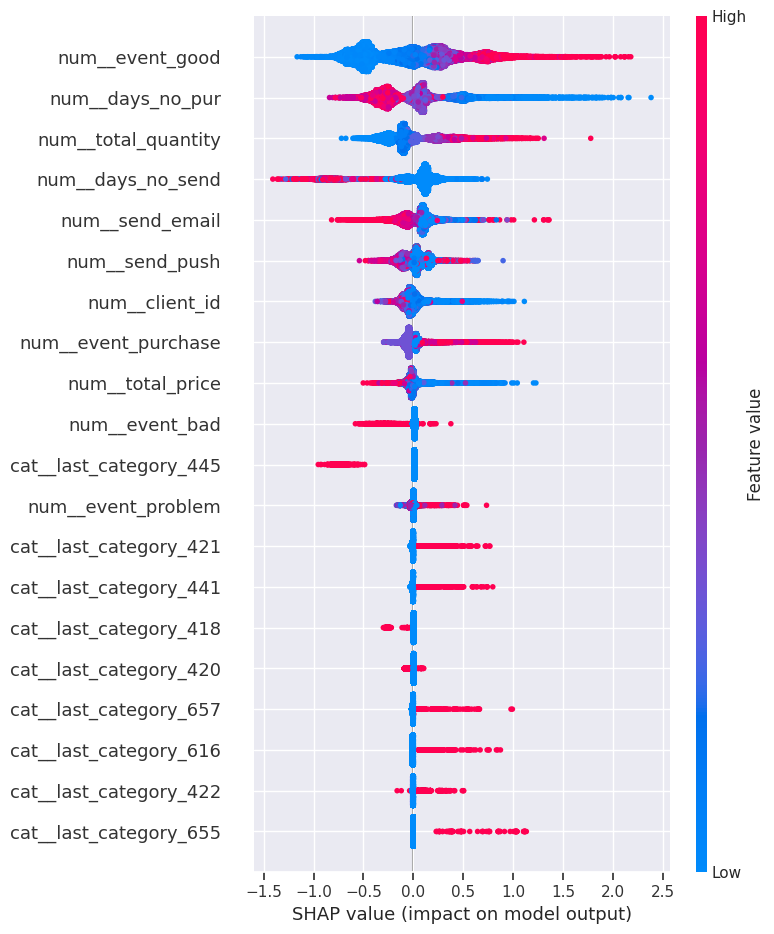

In [61]:
# Извлекаем объект преобразователя из обученного пайплайна
preprocessor = grid.best_estimator_.named_steps['preprocessor']
X_train_processed = preprocessor.transform(X_train)

# Попытаемся получить имена признаков после трансформаций
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception as e:
    print("Не удалось автоматически получить имена признаков. Продолжим без них.")
    feature_names = None

# Извлекаем лучшую модель
lgbm_model = grid.best_estimator_.named_steps['models']

# Создаём SHAP Explainer для модели на деревьях
explainer = shap.TreeExplainer(lgbm_model)

# Вычисляем SHAP-значения для обучающих данных
# Для классификации explainer возвращает список массивов, по одному для каждого класса.
shap_values = explainer.shap_values(X_train_processed)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Строим beeswarm-диаграмму
shap.summary_plot(
    shap_values_to_plot, 
    X_train_processed, 
    feature_names=feature_names, 
    plot_type="dot"
)

Топ-5 самых важных признаков для модели оказались: **event_good**, **days_no_pur**, **total_quantity**, **days_no_send** и **send_email**.

### 6.4 Выводы

Подготовили данные и обучили модель МО. Лучшей моделью оказалась **LGBMClassifier(n_estimators=51, num_leaves=21, reg_alpha=0.5)**. Метрика ROC-AUC лучшей модели на тренировочных данных - **0.72**, а на тестовых - **0.733**. Эти показатели больше целевого значения, к которому мы стремились. 

Топ-5 самых важных признаков для модели оказались: **event_good**, **days_no_pur**, **total_quantity**, **days_no_send** и **send_email**.

## 7. Выводы

Установили все необходимые библиотеки. Создали функцию для первичного анализа данных.

Данные в `apparel-purchases` имееют **202208 строк**. Количество явных дубликатов - **73020**, что составляет примерно 1/3 от общего числа. Количество пропусков 0. Тип дынных в столбце **date** имеет не корректный тип данных.

Посмотрели на количество уникальных значений в столбце **quantity**, попробывали понять почему может быть такое большое количество явных дубликатов. Большинство товаров куплено по 1 шт. Возможно эта ошибка записи данных, либо товары имеют разную спецификацию (цвет, размер). Если мы их удалим то потеряем около 1/3 данных поэтому оставим.

Данные в `apparel-messages` имеют **12739797 строк**. Количество явных дубликатов **48610**, что меньше 1%. Скорее всего это ошибка записи данных. Нужно будет их удалить. Количество пропусков 0. Не корректные типы данных в **date** и **created_at**.

Данные в `apparel-target_binary` содержит целевой признак и имеет **49849 строк**. Количество явных дубликатов 0. Количество пропусков 0.

Посмотрели на данные поглубже с помощью вывода уникальных значений.

**Состав данных в `purchases`:**
- 49849 данных уникальных пользователей;
- 16 вариантов кол-ва покупок за одну запись (самое маленькое число - 1, самое больше - 30);
- 3642 различных видов цен за товар;
- категории имеют вложенные категории и подкатегорию, уникальность таких комбинаций - 933;
- покупки были совершены в 642 днях за выбраннй период;
- покупателям было отправлено 50204 уникальных сообщения.

**Состав данных `messages`:**
- 2709 уникальных рассылок;
- данные о 53329 клиентах;
- 9061667 уникальных сообщений;
- 11 уникальных действий совершенных с сообщением (отправлено, открыто, нажато, куплено и так далее);
- 2 канала рассылок - через мобильное уведомление и чуть меньше через электронную почту;
- 638 уникальной даты сообщений;
- 4103539 значеней не только даты, но у разного времени в течение дня.

**Состав данных `target`:**
- все данные о клиентах уникальны, так как количество строк совпадает с количеством **client_id**;
- два вида целевого значения: 0 и 1.

В прошлых шагах мы выявили дубликаты в данных `messages`, которые мы удалили. И изменили типы данных в столбцах со временем на корректные.

**Создали новые признаки в `purchases`.** 
Новые признаки: первая и последняя категория **first_category и last_category**. Мы не знаем, что это конкретно за категории и как они иногда изменяются. Скорее всего самая первая цифра эта главная категория, а последняя цифра это итоговый купленный товар. Первые числа в категориях идут по возрастанию, а у последней цифры такое не наблюдается. Поэтому выделим первую и послденнюю категорию в отдельные столбцы. После группировки данных создали новый признак: количество дней без покупки **days_no_pur**.

**Создали новые признаки в `messages`.**
Новые признаки: типы и количество эвентов в сообщениях **event_send, event_purchase, event_good, event_bad', event_problem**. Количество отправленных сообщений с учетом канала взаимодействия **send_email, send_push**. Дата последнего отправленного сообщения **last_send_date**. После группировки данных создали новый признак: количество дней прошедших с последней отправки сообщения **days_no_send**.

Удалили лишние столбцы, которые являются производными от других столбцов и столбцы с явной корреляцией.

**Объединили три таблицы в одну**. После объединения таблиц у нас получилось **49848 строк**. Количество явных дубликатов 0. Есть по одному пропуску в **first_category** и **last_category** и 7867 пропусков в столбцах из таблицы **messages**. Так как данных много и не хочется их терять, а понять были ли отправлены какие-нибудь сообщения этим покупателям мы не можем, поэтому заполнили пропуски нулями.

После построения графика для целевого признака мы явно наблюдаем дисбаланс целевого признака **98.1%** со значением 0 и **1.9%** со значением 1.

Построили графики для числовых столбцов. После построения графиков и изучения данных мы увидели, что:
- количество **купленного товара** чаще всего приходится около **2** на клиента, при этом самое большое количество **355**;
- **сумма покупок** на клиента чаще всего составялет около **2929**, а самая большая **540408**;
- кол-во **дней без покупок** чаще всего находится около **250** и более **600** дней;
- кол-во **отправленных сообщений** самое большое приходится до **150 шт**, при этом среднее значение близко к медионному и составляет **362**;
- сообщений с **эвентом покупка** чаще всего **1** на человека, а самое большое **81**;
- сообщений с **положительным эвентом** чаще всего меньше **30** на клиента, а самое большое **1437**;
- сообщений с **отрицательным эвентом** чаще всего около **0** на клиента, а самое большое **80**;
- сообщений с **эвентом тех проблем** чаще всего около **0** на клиента, а самое большое **134**;
- сообщений отправленных **электронной почтой** чаще всего до **25**, а медианное значение **63**, самое большое число **321**;
- сообщений отправленных **уведомлениями на мобильный** чаще всего до **100**, а медианное значение **51**, самое большое число **2152**;
- дней без отправки сообщений меданное значение **1**, а смое большое число **638**.

Мы видим что все нет данных у которых нормальное распределение. И много столбцов с выбросами. Наши модели должны нормально отработать эти выбросы, но если мы не сможем приблизиться к целевым показателям, то нужно будет избавиться от выбросов.

Построили графики для категориальных признаков. После построения графиков для категориальных данных мы увидели, что:
- самая популярная главная категория с большим отрывом является **4**, на втором месте **5562**, на третьем **2**;
- самая поплярная последняя категория **431**, на втором месте **420**, на третьем месте **432**.

Убрали столбец **client_id** и построили матрицу корреляции. После построения матрицы корреляции мы видим, что есть почти прямая корреляция у **first_category** и **last_category**, оставим только 1 категорию. Есть корреляция между признакми **event_send**, **send_mail** и **send_push**. Убрали столбец **event_send**.

Подготовили данные и обучили модель МО. Лучшей моделью оказалась **LGBMClassifier(n_estimators=51, num_leaves=21, reg_alpha=0.5)**. Метрика ROC-AUC лучшей модели на тренировочных данных - **0.72**, а на тестовых - **0.733**. Эти показатели больше целевого значения, к которому мы стремились. 

Топ-5 самых важных признаков для модели оказались: **event_good**, **days_no_pur**, **total_quantity**, **days_no_send** и **send_email**.